In [1]:
from SimPEG import *
from SimPEG import EM
from scipy.constants import mu_0
import numpy as np
import scipy.sparse as sp
from simpegEMIP.StretchedExponential import SEInvImpulseProblem, SESurvey
import matplotlib.pyplot as plt
from pymatsolver import PardisoSolver
from simpegem1d import DigFilter
%matplotlib inline

def ColeColePelton(f, sigmaInf, eta, tau, c):
    w = 2*np.pi*f
    return sigmaInf*(1 - eta/(1 + (1-eta)*(1j*w*tau)**c))

def ColeColeSeigel(f, sigmaInf, eta, tau, c):
    w = 2*np.pi*f
    return sigmaInf*(1 - eta/(1 + (1j*w*tau)**c))
time = np.logspace(-6,np.log10(0.01), 41)
# plt.loglog(time, true, 'k', lw=1)
# plt.loglog(time, approx, 'r.')
# time = np.logspace(-3,np.log10(4), 41)
wt, tbase, omega_int = DigFilter.setFrequency(time)
frequency = omega_int / (2*np.pi)
siginf, eta0, tau0, c0 = 1., 0.8, 0.003, 0.6
sigma = ColeColeSeigel(frequency, siginf, eta0, tau0, c0)
sigTCole = DigFilter.transFiltImpulse(sigma, wt, tbase, omega_int, time, tol=1e-12)

In [2]:
wires = Maps.Wires(('eta', 1), ('tau', 1), ('c', 1))
taumap = Maps.ExpMap(nP=1)*wires.tau
survey = SESurvey()
dtrue = -sigTCole
survey.dobs = dtrue
m1D = Mesh.TensorMesh([np.ones(3)])
prob = SEInvImpulseProblem(m1D, etaMap = wires.eta, tauMap = taumap, cMap=wires.c)
prob.time = time
prob.pair(survey)
m0 = np.r_[eta0, np.log(tau0), c0]

In [5]:
perc = 0.01
dmisfitpeta = DataMisfit.l2_DataMisfit(survey)
dmisfitpeta.W = 1/(abs(survey.dobs)*perc)
reg = Regularization.SimpleSmall(m1D)
opt = Optimization.ProjectedGNCG(maxIter = 5)
invProb = InvProblem.BaseInvProblem(dmisfitpeta, reg, opt)
# Create an inversion object
target = Directives.TargetMisfit()
betaSch = Directives.BetaSchedule(coolingFactor=1, coolingRate=1)
# invProb.beta = 0.
inv = Inversion.BaseInversion(invProb, directiveList=[betaSch, target])
reg.mref = 0.*m0
prob.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')
opt.tolX = 1e-20
opt.tolF = 1e-20
opt.tolG = 1e-20
opt.eps = 1e-20
# opt.lower = 0.
mopt = inv.run(m0)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+00  4.66e+03  1.74e+01  4.68e+03    1.20e+05      0              
   1  1.00e+00  8.29e+02  1.73e+01  8.47e+02    5.48e+03      0              
   2  1.00e+00  2.23e+02  1.89e+01  2.42e+02    4.11e+03      0   Skip BFGS  
   3  1.00e+00  2.13e+02  1.88e+01  2.32e+02    6.76e+01      0              
   4  1.00e+00  2.13e+02  1.87e+01  2.32e+02    3.89e+00      0   Skip BFGS  
   5  1.00e+00  2.13e+02  1.87e+01  2.32e+02    2.59e-02      0   Skip BFGS  
------------------------- STOP! ---------------

In [6]:
def ColeSEImpulse(time, eta, tau, c):    
    return eta*c/time*((time/tau)**c)*np.exp(-(time/tau)**c)
def ColeSEImpulseApprox(time, eta, tau, c):    
    m = eta*c/(tau**c)    
    peta = m*time**(c-1.) * (1. - (time/tau)**c )  
    return peta

True      eta, tau and c = 8e-01, 3e-03 and 0.6
Initial   eta, tau and c = 8e-01, 3e-03 and 0.6
Estimated eta, tau and c = 7e-01, 2e-03 and 0.6


Text(0,0.5,'Resistivity (ohm-m)')

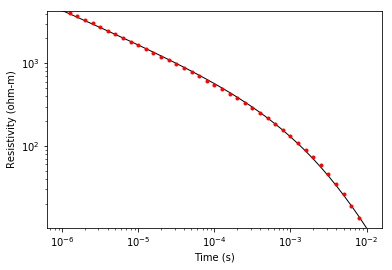

In [8]:
nskip=1
plt.loglog(prob.time, survey.dobs, 'k', lw=1)
plt.loglog(prob.time, invProb.dpred, 'r.')
vmin, vmax = survey.dobs.min(), survey.dobs.max()
plt.ylim(vmin, vmax)
# legend(("pred", "obs"))
print (("True      eta, tau and c = %.e, %.e and %3.1f")%(eta0, tau0, c0))
print (("Initial   eta, tau and c = %.e, %.e and %3.1f")%(eta0, tau0, c0))
print (("Estimated eta, tau and c = %.e, %.e and %3.1f")%(mopt[0], np.exp(mopt[1]), mopt[2]))

plt.xlabel("Time (s)")
plt.ylabel("Resistivity (ohm-m)")

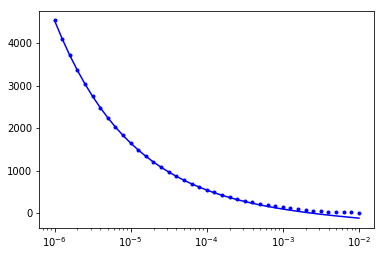

In [9]:
plt.semilogx(prob.time, ColeSEImpulseApprox(prob.time, mopt[0], np.exp(mopt[1]), mopt[2]), 'b-')
plt.semilogx(prob.time, ColeSEImpulse(prob.time, mopt[0], np.exp(mopt[1]), mopt[2]), 'b.')


In [28]:
eta, tau, c = mopt[0], np.exp(mopt[1]), mopt[2]

In [29]:
print (eta, tau, c)

0.690075646544855 0.002341720023417556 0.5747786790159198


In [11]:
cs, ncx, ncz, npad = 5., 25, 20, 18
hx = [(cs,ncx), (cs,npad,1.3)]
hz = [(cs,npad,-1.3), (cs,ncz), (cs,npad,1.3)]
mesh = Mesh.CylMesh([hx,1,hz], '00C')    
sigmaInf = np.ones(mesh.nC)* 0.01
airind = mesh.gridCC[:,2]>0.
sigmaInf[airind] = 1e-8

In [12]:
# timeSteps = np.r_[np.ones(10)*1e-5, np.ones(10)*5e-5, np.ones(10)*1e-4, np.ones(10)*5e-4, ]
# times = np.r_[0., np.cumsum(timeSteps)]
# nstep = len(timeSteps)
# mopt[1:] = 0.

In [13]:
rxloc = np.array([[50.5, 0., 0.]])
srcloc = np.array([[0., 0., 0.]])

In [14]:
rx = EM.TDEM.Rx.Point_dbdt(rxloc, np.logspace(-4, -2.5, 11), 'z')
src = EM.TDEM.Src.MagDipole([rx], loc=srcloc)
survey = EM.TDEM.Survey([src])
prb_em = EM.TDEM.Problem3D_b(mesh, sigmaMap=Maps.IdentityMap(mesh))
prb_em.timeSteps = [(1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20) ]
Solver = PardisoSolver
survey.pair(prb_em)

In [15]:
from SimPEG.EM.TDEM import Fields3D_e
class FieldsTDEMIP_e_from_b(Fields3D_e):
    """Fancy Field Storage for a TDEM survey."""
    knownFields = {'eSolution': 'E'}
    aliasFields = {
                    'e': ['eSolution', 'E', '_e'],
                    'b': ['eSolution', 'F', '_b'],
                    'dbdt': ['eSolution', 'F', '_dbdt'],
                  }    
    def startup(self):
        pass

In [16]:
b0 = src.bInitial(prb_em)
e0 = np.zeros((mesh.nE,1))
j0 = np.zeros((mesh.nE,1))

C = mesh.edgeCurl
MfMui = mesh.getFaceInnerProduct(1./mu_0)
Me = mesh.getEdgeInnerProduct()
se_0 = C.T*MfMui*b0
se_0 = np.atleast_2d(se_0).T
prb_em.fieldsPair = FieldsTDEMIP_e_from_b
current = np.zeros_like(prb_em.times)
current[0] = 1.
timeSteps = prb_em.timeSteps

In [19]:
def getpetaI(time):   
    m = eta*c/(tau**c)    
    peta = m*time**(c-1.)*np.exp(-(time/tau)**c)
    return peta
                                             
def getKappa(dt):    
    m = eta*c/(tau**c)
    kappa =  m / (c+1.) * (dt) ** c - m / ((2*c+1.) * tau**c ) * (dt) ** (2*c)
    return  - sigmaInf * kappa

def getGamma(dt):
    m = eta*c/(tau**c)
    gamma = m / (c*(c+1.)) * (dt)** c - m / (2*c*(2*c+1.) * tau**c ) * (dt) ** (2*c)
    return - sigmaInf * gamma

def MeK(dt):
    kappa = getKappa(dt)
    return mesh.getEdgeInnerProduct(kappa)      

def MeA(dt):
    gamma = getGamma(dt)
    val = sigmaInf + gamma
    return mesh.getEdgeInnerProduct(val)      

def MeCnk(n, k):
    temp = np.ones(mesh.nC)
    temp[airind] = 0.    
    tn = prb_em.times[n]
    tk = prb_em.times[k]
    val = -sigmaInf* temp *getpetaI(tn-tk)
    return mesh.getEdgeInnerProduct(val)

def getA(tInd):
    """
        :param int tInd: Time index
        :rtype: scipy.sparse.csr_matrix
        :return: A
    """
    dt = timeSteps[tInd]  
    return C.T*MfMui*C + 1./dt * MeA(dt)
    
def getJpol(tInd, F):
    """
        Computation of polarization currents
    """
    dt = timeSteps[tInd]
#     jpol = (dt/2)*MeCnk(tInd+1,tInd)*F[:,'e',tInd]    
    jpol = MeK(dt)*F[:,'e',tInd]    
    for k in range(tInd): 
        dt = timeSteps[k]
        jpol += (dt/2)*MeCnk(tInd+1,k)*F[:,'e',k]
        jpol += (dt/2)*MeCnk(tInd+1,k+1)*F[:,'e',k+1]
    return jpol

def getRHS(tInd, F, jpoldiff):
    dt = timeSteps[tInd]   
    dtlast = timeSteps[tInd-1]   
    RHS = - 1./ dt * (se_0*(current[tInd+1]-current[tInd])) \
          + 1./ dt * MeA(dtlast) * F[:,'e',tInd] \
          - 1./ dt * jpoldiff
    return RHS

solverOpts = {}  
verbose = True

def forward(m, F):
    curModel = m
    dtFact = None
    Ainv   = None
    jpol_last= Me*j0
    for tInd, dt in enumerate(timeSteps):
        if dt != dtFact:
            dtFact = dt
            if Ainv is not None:
                Ainv.clean()
            A = getA(tInd)
            if verbose: print ('Factoring...   (dt = %e)'% dt)
            Ainv = Solver(A, **solverOpts)
            if verbose: print ('Done')
        jpol = getJpol(tInd, F)    
        jpoldiff = jpol-jpol_last
        rhs = getRHS(tInd, F, jpoldiff)
        if verbose: print ('    Solving...   (tInd = %d)'% tInd)
        sol = Ainv * rhs  
        sol = np.atleast_2d(sol).T
        F[src, 'eSolution', tInd+1] = sol
        if verbose: print ('    Done...')
#         Mej = MeA(dt)*sol + jpol
        jpol_last = jpol.copy()
    Ainv.clean()

In [20]:
F = prb_em.fieldsPair(mesh, survey)
F[src,'eSolution',0] = np.zeros(mesh.nE)
forward(True, F)

Factoring...   (dt = 1.000000e-06)
Done
    Solving...   (tInd = 0)
    Done...
    Solving...   (tInd = 1)
    Done...
    Solving...   (tInd = 2)
    Done...
    Solving...   (tInd = 3)
    Done...
    Solving...   (tInd = 4)
    Done...
Factoring...   (dt = 2.500000e-06)
Done
    Solving...   (tInd = 5)
    Done...
    Solving...   (tInd = 6)
    Done...
    Solving...   (tInd = 7)
    Done...
    Solving...   (tInd = 8)
    Done...
    Solving...   (tInd = 9)
    Done...
Factoring...   (dt = 5.000000e-06)
Done
    Solving...   (tInd = 10)
    Done...
    Solving...   (tInd = 11)
    Done...
    Solving...   (tInd = 12)
    Done...
    Solving...   (tInd = 13)
    Done...
    Solving...   (tInd = 14)
    Done...
Factoring...   (dt = 1.000000e-05)
Done
    Solving...   (tInd = 15)
    Done...
    Solving...   (tInd = 16)
    Done...
    Solving...   (tInd = 17)
    Done...
    Solving...   (tInd = 18)
    Done...
    Solving...   (tInd = 19)
    Done...
    Solving...   (tInd = 20)
 

In [21]:
dbdt = C*F[src, 'eSolution', :]
Pfz = mesh.getInterpolationMat(rxloc, locType="Fz")

In [22]:
data = Pfz*dbdt

In [23]:
from EMTD.Utils import hzAnalyticDipoleT, hzAnalyticDipoleT_CC

In [24]:
Div = prb_em.timeMesh.faceDiv
hz = hzAnalyticDipoleT(rxloc[0][0], prb_em.timeMesh.gridFx, 0.01)
hzip = hzAnalyticDipoleT_CC(rxloc[0][0], prb_em.timeMesh.gridFx[1:], sigmaInf=0.01, eta=eta0, tau=tau0, c=c0, model="Seigel")
P = prb_em.timeMesh.getInterpolationMat(prb_em.times[10:])
dhzdt = P*Div*hz
dhzdtip = P*Div*np.r_[0., hzip]

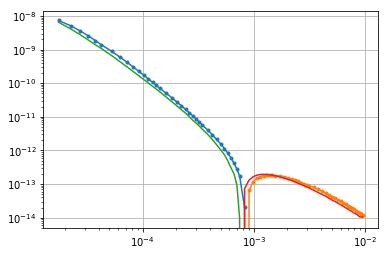

In [25]:
scale = 1.
plt.loglog(prb_em.times[10:], data.flatten()[10:], '.-')
plt.loglog(prb_em.times[10:], -data.flatten()[10:], '.-')
plt.loglog(prb_em.times[10:], -dhzdtip.flatten()*mu_0*scale, '-')
plt.loglog(prb_em.times[10:], dhzdtip.flatten()*mu_0*scale, '-')
# plt.loglog(prb_em.times[10:], -dhzdt.flatten()*mu_0)
plt.grid(True)

In [27]:
print (eta, tau, c)

0.690075646544855 0.002341720023417556 0.5747786790159198


In [26]:
F[src,'e',1]

array([[-1.47123263e-14],
       [-2.91606326e-14],
       [-4.36793957e-14],
       ...,
       [-6.02897974e-09],
       [-5.61635669e-09],
       [-4.28253903e-09]])

In [ ]:
se_0

In [ ]:
MfMui.diagonal()